# Chapter 11: Training Deep Neural Networks

In [1]:
# Libraries

import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Activations

### 1.1 Vanishing and Exploding Gradients

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

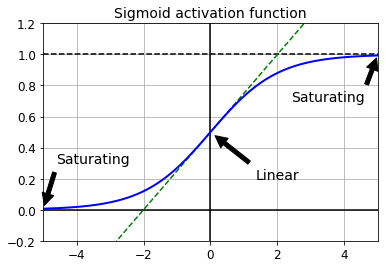

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### 1.2 Xavier-He Initialization

- _Idea_ : want variance of outputs to be approximately equal to variance of inputs (before/after flow in backprop)

- The following holds for the sigmoid initialization:

$$\mathrm{Glorot \; normal \; init} \sim \mathcal{N} \bigg(0, \, \frac{2}{a^{[\ell]} + a^{[\ell - 1]}} \bigg)$$
$$\mathrm{Glorot \; uniform \; init} \sim U \bigg[-\sqrt{\frac{6}{a^{[\ell]} + a^{[\ell - 1]}}} , \, \sqrt{\frac{6}{a^{[\ell]} + a^{[\ell - 1]}}} \bigg]$$

For $a_{\mathrm{avg}} = \frac{a^{[\ell]} + a^{[\ell - 1]}}{2}$, have:
   - __Glorot__ : for tanh, logistic, softmax -- $\sigma^2 = \frac{1}{a_{\mathrm{avg}}}$
   - __He__ : for ReLU -- $\sigma^2 = \frac{2}{a^{[\ell - 1]}}$

In [4]:
# List of initializations

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
# By default, Karas uses Glorot uniform
# Can change to He:

keras.layers.Dense(10, activation = "relu", kernel_initializer = "he_normal")

In [6]:
# Can manually adjust He based on average rather than input dimension:

init = keras.initializers.VarianceScaling(scale = 2.0, mode = "fan_avg", distribution = "uniform")
keras.layers.Dense(10, activation = "relu", kernel_initializer = init)

### 1.3 Nonsaturating Activation Functions

#### 1.3.1 Leaky ReLU

- Problem with ReLU: activations "die" because of 0 derivative on the left
- Neuron dies when weighted sum of inputs negative for all instances in training set -- will be unaltered by GD!
- Attempt to solve by leaky ReLU: $\mathrm{LeakyReLU}_{\alpha}(z) = \max(\alpha z, \, z)$

__Notes__ :
   - Typically, large leak $\alpha = 0.2$ might do better than small $\alpha = 0.01$
   - _Randomized leaky ReLU_ : RRELU -- choose $\alpha$ at random during trainign, and fix to average value during test
   - _Parameterized leaky ReLU_ : PReLU -- learn $\alpha$ during training (works well on large datasets)

In [7]:
def leaky_relu(z, alpha = 0.01):
    return np.maximum(alpha*z, z)

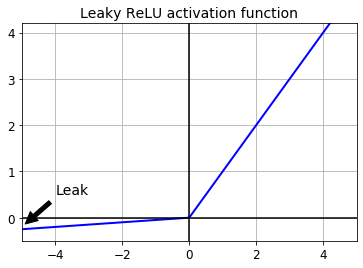

In [8]:
# Plot the leaky ReLU

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [9]:
# List of built-in activations

[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
# List of ReLU variants

[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
# Example: fashion MNIST using leaky ReLU

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
# Toy network

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer = "he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer = "he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation = "softmax")
])

In [13]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 2s 981us/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 2s 914us/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 924us/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_acc

#### 1.3.2 PReLU

In [15]:
# Learn alpha factor through training

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer = "he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer = "he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation = "softmax")
])

In [16]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 2s 961us/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 2s 965us/step - loss: 0.6965 - accuracy: 0.7694 - val_loss: 0.6564 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 2s 976us/step - loss: 0.6330 - accuracy: 0.7908 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_acc

#### 1.3.3 ELU

- "ELU" = exponential linear unit

$$\mathrm{ELU}_{\alpha}(z) = \begin{cases} \alpha \cdot (\exp(z) - 1) & \text{if } z < 0 \\ z & \text{if } z \geq 0\end{cases}$$

- __Pros__ :
   - Solves nonzero gradient for $z < 0$ like ReLU
   - For $\alpha = 1$, is smooth everywhere
   - Faster training convergence
   
- __Cons__ :
   - Slower to compute than ReLU
   - Slower at test time

In [18]:
# ELU function

def elu(z, alpha = 1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

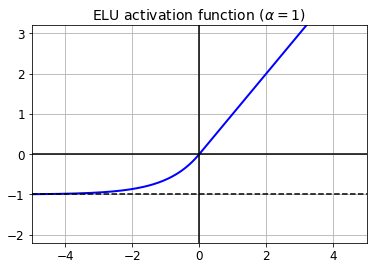

In [19]:
# ELU plot

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [20]:
# Can specify ELU function when building layers in tf

keras.layers.Dense(10, activation = "elu")

#### 1.3.4 SELU

- "SELU" : scaled ELU

- __Pros__ :
    - Building Dense-only NN with SELUs preserves mean 0 and sd 1 throughout traning (_self-normalization_)
    - Significantly outperforms other activations in dense, deep NNs
    - Need: input features standardized to std normal, weights init with LeCun normal, and MUST have sequential architecture
    - Can sometimes help in sequential CNNs
- __Cons__ :
    - Very specific use case
    - CANNOT use L1 or L2 regularization!!
    - Also can't use: regular dropout, max-norm, skip connections, or non-sequential topologies

In [21]:
# Make selu function params

from scipy.special import erfc

# alpha and scale to self-normalize with mean 0, sd 1

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

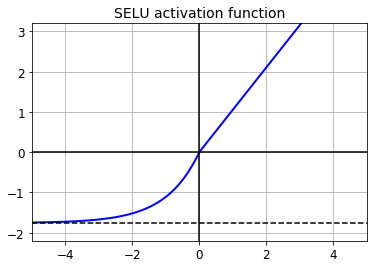

In [23]:
# Plot

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [24]:
# Implement SELU NN

np.random.seed(42)
Z = np.random.normal(size = (500, 100)) # standardized inputs

for layer in range(1000):
    W = np.random.normal(size = (100, 100), scale = np.sqrt(1 / 100)) # LeCun init
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis = 0).mean()
    stds = np.std(Z, axis = 0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [25]:
# keras selu

keras.layers.Dense(10, activation = "selu", kernel_initializer = "lecun_normal")

In [26]:
# Try NN for fashion MNIST with 100 hidden layers using selu!

np.random.seed(42)
tf.random.set_seed(42)

In [27]:
# Build the model

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = "selu", kernel_initializer = "lecun_normal"))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
    
model.add(keras.layers.Dense(10, activation = "softmax"))

In [28]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [29]:
# Scale the training set

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
# Train

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.9940 - accuracy: 0.6219 - val_loss: 0.7349 - val_accuracy: 0.7082
Epoch 2/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6785 - accuracy: 0.7460 - val_loss: 0.5819 - val_accuracy: 0.7848
Epoch 3/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5810 - accuracy: 0.7845 - val_loss: 0.5928 - val_accuracy: 0.7776
Epoch 4/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5363 - accuracy: 0.8053 - val_loss: 0.4840 - val_accuracy: 0.8248
Epoch 5/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5355 - accuracy: 0.8129 - val_loss: 0.4743 - val_accuracy: 0.8404


In [31]:
# Contrast this with a normal ReLU with 100 layers

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid)) # worse performance!!

Epoch 1/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.8779 - accuracy: 0.2445 - val_loss: 1.3530 - val_accuracy: 0.3936
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.1823 - accuracy: 0.4929 - val_loss: 0.8976 - val_accuracy: 0.6058
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0236 - accuracy: 0.5790 - val_loss: 0.9645 - val_accuracy: 0.6104
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8173 - accuracy: 0.6759 - val_loss: 0.7479 - val_accuracy: 0.7156
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7356 - accuracy: 0.7219 - val_loss: 0.7024 - val_accuracy: 0.7348


## 2. Other Normalization Methods

### 2.1 BatchNorm

- Vanishing/exploding gradients can return during training; BatchNorm lets network learn optimal shift/scale for parameters
- Evaluates mean, std of input over current mini-batch

#### 2.1.1 BatchNorm using keras

In [32]:
# Example BatchNorm in network

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation = "softmax")
])

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [34]:
# Examine the trainable params in the batchnorm layer

bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [35]:
bn1.updates

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[]

In [36]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [37]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5525 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5753 - accuracy: 0.8031 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5189 - accuracy: 0.8204 - val_loss: 0.4375 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4826 - accuracy: 0.8324 - val_loss: 0.4151 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3996 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4397 - accuracy: 0.8475 - val_loss: 0.3867 - val_accuracy: 0.8700
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4242 - accuracy: 0.8515 - val_loss: 0.3763 - val_accuracy:

In [38]:
# Note -- technically can throw away the bias term!
# Also, applying BatchNorm before activation can work better

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [39]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7816
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6790 - accuracy: 0.7792 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4434 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4263 - val_accuracy: 0.8548
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4712 - accuracy: 0.8397 - val_loss: 0.4130 - val_accuracy:

#### 2.1.2 Notes on BatchNorm

- Can change `momentum` for exponential moving average; typically want $\approx 1$ (0.9, 0.99, or 0.999)
- Also, by default BatchNorm normalizes the -1 axis (last axis, using the means and sd across the other axes)
    - For 2D, this normalizes across instances
    - For 3D, by default normalizes all pixels in a given column with the same mean and sd (`dim = [batch_size, height, width]`)
    - For independent pixels in 3D: `axis = [1, 2]`

### 2.2 Gradient Clipping

Alternatively, can just clip gradients so they never exceed a given threshold; common in RNNs due to difficulty of implementing RNN BatchNorm.

All keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [41]:
# Clipvalue hard clips based on the number
# Con: can change the gradient direction by a good amount

optimizer = keras.optimizers.SGD(clipvalue = 1.0)

In [42]:
# Clipnorm clips the L2 norm to preserve direction of the vector!
# Con: can significantly reduce one component

optimizer = keras.optimizers.SGD(clipnorm = 1.0)

## 3. Further Model Optimization

### 3.1 Transfer Learning

_Example_: split fashion MNIST into two groups:
    1. `X_train_A` : all images exxcept sandals and shirts (class 5 and 6)
    2. `X_train_B` : just the first 200 images of sandals and shirts
    
Also split the val, test sets this way without restriction on number of images.

_Procedure_ :
    1. Train model on set A
    2. Transfer knowledge to task B
    
_Final note_ : won't work perfectly since this is a pixel-level sequential NN rather than a CNN

In [43]:
# Split the dataset

def split_dataset(X, y):
    # Set A
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # move class indices (7, 8, 9) -> (5, 6, 7)
    
    # Set B
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification: is it a shirt (class 6)
    
    # Return the two sets
    return((X[~y_5_or_6], y_A),
          (X[y_5_or_6], y_B))

In [44]:
# Set assignment

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

Check that the function worked:

In [45]:
X_train_A.shape

(43986, 28, 28)

In [46]:
X_train_B.shape

(200, 28, 28)

In [47]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [48]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

#### 3.1.1 Training the initial network

Since everything appears to have worked, move to training...

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

In [50]:
# Build the model

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape = [28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation = "selu"))
model_A.add(keras.layers.Dense(8, activation = "softmax"))

In [51]:
model_A.compile(loss = "sparse_categorical_crossentropy",
               optimizer = keras.optimizers.SGD(lr = 1e-3),
               metrics = ["accuracy"])

In [52]:
history = model_A.fit(X_train_A, y_train_A, epochs = 20,
                     validation_data = (X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3287 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8979
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2893 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2776 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2729 - accuracy: 0.9062 - val_loss: 0.2732 - val_accuracy: 0.9063
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2641 - accuracy: 0.9091 - val_loss: 0.2720 - val_accuracy:

In [53]:
# Save the results from model A

model_A.save("my_model_A.h5")

#### 3.1.2 Try task B without transfer learning

In [54]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape = [28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation = "selu"))
model_B.add(keras.layers.Dense(1, activation = "sigmoid"))

In [55]:
model_B.compile(loss = "binary_crossentropy",
               optimizer = keras.optimizers.SGD(lr = 1e-3),
               metrics = ["accuracy"])

In [56]:
history = model_B.fit(X_train_B, y_train_B, epochs = 20,
                     validation_data = (X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 19ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

#### 3.1.3 Transfer learning from model A

Model B got pretty good performance outright -- 97% on val set. Now, try transfer learning from model A:

In [58]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) # try use all layers except for the output
model_B_on_A.add(keras.layers.Dense(1, activation = "sigmoid"))

__Note__ : training `model_B_on_A` will also affect `model_A`!

To avoid this, need to _clone_ model A before reusing its layers, then copy its weights

In [59]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [60]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [61]:
# First, train only the output
history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 4,
                          validation_data = (X_valid_B, y_valid_B))

# Now, unfreeze the early layers and retrain a bit
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 16,
                          validation_data = (X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 18ms/step - loss: 0.5803 - accuracy: 0.6550 - val_loss: 0.5839 - val_accuracy: 0.6329
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 0.5436 - accuracy: 0.6700 - val_loss: 0.5463 - val_accuracy: 0.6805
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 0.5065 - accuracy: 0.7200 - val_loss: 0.5140 - val_accuracy: 0.7079
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.4748 - accuracy: 0.7450 - val_loss: 0.4852 - val_accuracy: 0.7353
Epoch 1/16
7/7 [==============================] - 0s 18ms/step - loss: 0.3963 - accuracy: 0.8150 - val_loss: 0.3460 - val_accuracy: 0.8671
Epoch 2/16
7/7 [==============================] - 0s 6ms/step - loss: 0.2802 - accuracy: 0.9350 - val_loss: 0.2604 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.2087 - accuracy: 0.9650 - val_loss: 0.2110 - val_accuracy: 0.9554
Epoch 4/16
7/7 [====================

#### 3.1.4 Evaluation

In [62]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 767us/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407986164093, 0.9704999923706055]

In [63]:
model_B_on_A.evaluate(X_test_B, y_test_B) # good performance increase!

63/63 [==============================] - 0s 810us/step - loss: 0.0682 - accuracy: 0.9935


[0.0681760162115097, 0.9934999942779541]

### 3.2 Faster Optimizers

__Notes__ :
  - These techniques rely on _Jacobians_ (first-order partial derivs)
  - Produce dense models; can implement L1 regularization or zero out the small weights to save memory

#### 3.2.1 Momentum

Gradient used for _acceleration_ , not _velocity_ -- hyperparameter for "friction"

In [64]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9)

#### 3.2.2 Nesterov accelerated gradient

Try to aim for a point a little bit farther ahead in the momentum gradient update; generally faster than vanilla momentum

In [65]:
optimizer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9, nesterov = True)

#### 3.2.3 AdaGrad

Scales down gradient vector along steepest directions; decays the learning rate faster for steep dimensions

_Warning_ : stops too early when training NNs -- DO NOT USE!! Can still work on simpler algos

In [66]:
optimizer = keras.optimizers.Adagrad(lr = 0.001)

#### 3.2.4 RMSProp

AdaGrad idea, but accumulate only gradients from most recent iterations via exponential decay

In [67]:
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9)

#### 3.2.5 Adam

_Adaptive moment estimation_ : momentum ($\beta_1$) + RMSprop ($\beta_2$)

In [68]:
optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

#### 3.2.6 Adam variants

1. __AdaMax__ :
    - Adam scales by L2 norm of time-decayed gradients
    - AdaMax scaled by max of time-decayed gradients
    - Can improve stability, but Adam still tends to outperform
    
2. __Nadam__ :
    - Nadam = Nesterov + Adam for faster convergence
    - Nadam can beat Adam, but RMSprop can sometimes beat Nadam

In [69]:
# Adamax
optimizer = keras.optimizers.Adamax(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# Nadam
optimizer = keras.optimizers.Nadam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

## 4. Learning Rate Scheduling

- _One option_ :
    - Train model for few hundred iterations
    - Exponentially increase learning rate from small $\to$ large
    - Pick learning rate right before learning curve diverges
    - Re-initialize, and start over
    
- _Alternatively_ : start with large learning rate, and reduce once training stops with fast progress (__non-constant__ learning rate!)

### 4.1 Power Scheduling

$$ \eta(t) = \frac{\eta_0}{(1 + t/s)^c} $$

__Hyperparameters__:
   - $\eta_0 = $ initial learning rate
   - $c = $ power for decay (usually, $c = 1$)
   - $s = $ step size
   
_Idea_ :
   - After $s$ steps, down to $\eta_0/2$
   - After $s$ more steps, down to $\eta_0/3$
   - etc.
   
_Note_ : keras uses $c = 1$ and $s = 1/\mathrm{decay}$

#### 4.1.1 Example model

In [70]:
optimizer = keras.optimizers.SGD(lr = 0.01, decay = 1e-4)

In [71]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(10, activation = "softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [72]:
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4855 - accuracy: 0.8304 - val_loss: 0.4031 - val_accuracy: 0.8596
Epoch 2/25
1719/1719 [==============================] - 2s 972us/step - loss: 0.3780 - accuracy: 0.8659 - val_loss: 0.3715 - val_accuracy: 0.8726
Epoch 3/25
1719/1719 [==============================] - 2s 985us/step - loss: 0.3457 - accuracy: 0.8769 - val_loss: 0.3745 - val_accuracy: 0.8738
Epoch 4/25
1719/1719 [==============================] - 2s 957us/step - loss: 0.3250 - accuracy: 0.8827 - val_loss: 0.3502 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 2s 966us/step - loss: 0.3101 - accuracy: 0.8890 - val_loss: 0.3451 - val_accuracy: 0.8780
Epoch 6/25
1719/1719 [==============================] - 2s 966us/step - loss: 0.2966 - accuracy: 0.8935 - val_loss: 0.3420 - val_accuracy: 0.8820
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2867 - accuracy: 0.8973 - val_loss: 0.3361 - val

#### 4.1.2 Plot

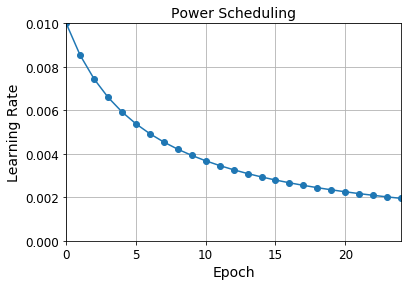

In [73]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay*epochs*n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize = 14)
plt.grid(True)
plt.show()

### 4.2 Exponential Scheduling

$$ \eta(t) = \eta_0 \cdot (0.1)^{\mathrm{epoch}\, / \, s} $$

Learning rate drops by factor of 10 every $s$ steps.

#### 4.2.1 Example model

In [74]:
# Start with lr = 0.01, and major drop every 20 steps

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [75]:
# For arbitrary starting point and drop schedule

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

In [76]:
# Example model

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(10, activation = "softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
n_epochs = 25

In [77]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid),
                   callbacks = [lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8249 - accuracy: 0.7602 - val_loss: 0.7496 - val_accuracy: 0.7568
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6891 - accuracy: 0.7935 - val_loss: 0.9613 - val_accuracy: 0.8076
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5933 - accuracy: 0.8199 - val_loss: 0.7109 - val_accuracy: 0.8148
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5585 - accuracy: 0.8311 - val_loss: 0.5771 - val_accuracy: 0.8408
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4803 - accuracy: 0.8489 - val_loss: 0.4778 - val_accuracy: 0.8606
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4498 - accuracy: 0.8595 - val_loss: 0.4780 - val_accuracy: 0.8494
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4190 - accuracy: 0.8660 - val_loss: 0.4853 - val_accuracy:

#### 4.2.2 Plot

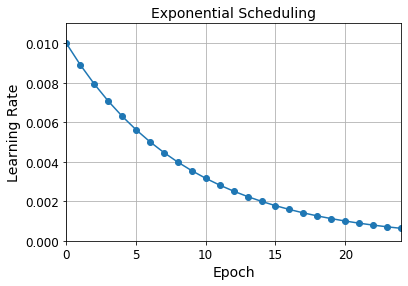

In [78]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [79]:
# Alternate implemention with learning rate

def exponential_decay_fn(epoch, lr):
    return lr * 0.1 **(1 / 20)

#### 4.2.3 Alternate implementation: update at every iteration

In [80]:
# Implement manual callback class

K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s = 40000):
        super().__init__()
        self.s = s
        
    def on_batch_begin(self, batch, logs = None):
        # Note: 'batch' argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))
        
    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [81]:
# Model implementation

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(10, activation = "softmax")
])

In [82]:
# Implement hyperparams

lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25
s = 20 * len(X_train) // 32 # number of steps in 20 epochs for batch size 32
exp_decay = ExponentialDecay(s)

history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid),
                   callbacks = [exp_decay])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8063 - accuracy: 0.7646 - val_loss: 0.6935 - val_accuracy: 0.7778
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6422 - accuracy: 0.8045 - val_loss: 0.6819 - val_accuracy: 0.8010
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6115 - accuracy: 0.8155 - val_loss: 0.7762 - val_accuracy: 0.7614
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5157 - accuracy: 0.8385 - val_loss: 0.4861 - val_accuracy: 0.8474
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4658 - accuracy: 0.8542 - val_loss: 0.4991 - val_accuracy: 0.8528
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4420 - accuracy: 0.8589 - val_loss: 0.4753 - val_accuracy: 0.8604
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3911 - accuracy: 0.8747 - val_loss: 0.4568 - val_accuracy:

#### 4.2.4 Granular exponential scheduling plot

In [83]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

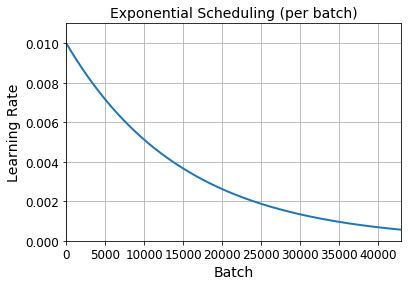

In [84]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 4.3 Piecewise Constant Scheduling

#### 4.3.1 Example

In [85]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [86]:
# More malleable implementation

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [87]:
# Model implementation

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid),
                   callbacks = [lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8249 - accuracy: 0.7615 - val_loss: 0.8016 - val_accuracy: 0.7146
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9107 - accuracy: 0.7304 - val_loss: 0.7659 - val_accuracy: 0.7146
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9254 - accuracy: 0.6922 - val_loss: 1.2825 - val_accuracy: 0.5496
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9780 - accuracy: 0.6599 - val_loss: 0.9964 - val_accuracy: 0.6506
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0131 - accuracy: 0.6569 - val_loss: 1.2195 - val_accuracy: 0.7074
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7516 - accuracy: 0.7118 - val_loss: 0.7629 - val_accuracy: 0.7352
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6738 - accuracy: 0.7351 - val_loss: 0.6855 - val_accuracy:

#### 4.3.2 Performance

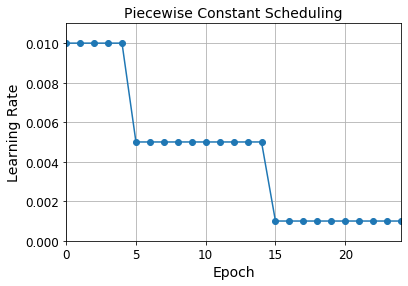

In [88]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 4.4 Performance Scheduling

Measure validation error every $N$ steps and reduce $\eta$ by factor of $\lambda$ when error stops dropping.

#### 4.4.1 Example

In [89]:
tf.random.set_seed(42)
np.random.seed(42)

In [90]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 5) # halve the learning rate if plateau for 5 epochs

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5886 - accuracy: 0.8079 - val_loss: 0.4821 - val_accuracy: 0.8510
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4936 - accuracy: 0.8401 - val_loss: 0.5928 - val_accuracy: 0.8242
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5079 - accuracy: 0.8430 - val_loss: 0.4815 - val_accuracy: 0.8606
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5073 - accuracy: 0.8467 - val_loss: 0.4904 - val_accuracy: 0.8524
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5339 - accuracy: 0.8482 - val_loss: 0.5004 - val_accuracy: 0.8418
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5181 - accuracy: 0.8509 - val_loss: 0.7802 - val_accuracy: 0.8486
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5329 - accuracy: 0.8516 - val_loss: 0.6728 - val_accuracy:

#### 4.4.2 Learning rate and validation loss vs. epoch

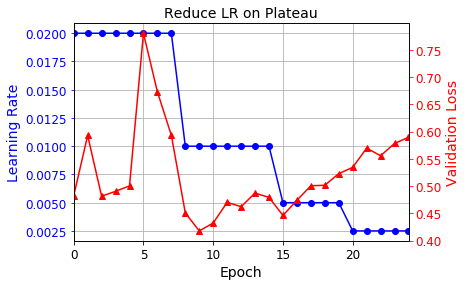

In [91]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 4.5 tf.keras Schedulers

`tf.keras` allows for learning rate schedules through `keras.optimizers.schedules`!

_Note_ : this is specific ONLY to `tf.keras`, not the `keras` api!

In [92]:
# Example: re-implement exponential decay

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4894 - accuracy: 0.8273 - val_loss: 0.4096 - val_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 2s 968us/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3743 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 2s 962us/step - loss: 0.3487 - accuracy: 0.8762 - val_loss: 0.3734 - val_accuracy: 0.8690
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3264 - accuracy: 0.8836 - val_loss: 0.3496 - val_accuracy: 0.8796
Epoch 5/25
1719/1719 [==============================] - 2s 960us/step - loss: 0.3104 - accuracy: 0.8897 - val_loss: 0.3432 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 2s 968us/step - loss: 0.2958 - accuracy: 0.8953 - val_loss: 0.3411 - val_accuracy: 0.8816
Epoch 7/25
1719/1719 [==============================] - 2s 969us/step - loss: 0.2853 - accuracy: 0.8990 - val_loss: 0.3354 - val

In [93]:
# Alternate example: piecewise constant scheduling

learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [5.0 * n_steps_per_epoch, 15.0 * n_steps_per_epoch],
    values = [0.01, 0.005, 0.001])

### 4.6 1Cycle Scheduling

__Procedure__ :
   1. Start with initial learning rate $\eta_0$
   2. Grow linearly up to $\eta_1$ halfway through training
   3. Finish last few epochs by dropping rate down quickly, but still linearly
   
_Notes_ :
   - Choose $\eta_1$ by same approach as finding optimial LR
   - Make $\eta_0$ about 10x lower than $\eta_1$

_Momentum considerations_ :
   - For momentum, start high (0.95), then drop low linearly (e.g. 0.85), then bring back up to start by end of training
    
Somewhat complicated idea, but can boost performance by quite a bit

#### 4.6.1 Procedure to find $\eta_1$

In [94]:
# Learning rate model

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [95]:
# Learning rate search

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [96]:
# Plotting

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [97]:
# Compile the model

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])


430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3912


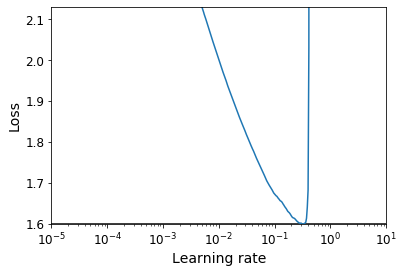

In [98]:
# Find the optimal learning rate

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

#### 4.6.2 1Cycle Implementation

In [99]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate = None,
                 last_iterations = None, last_rate = None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                    self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                    self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
# Train the model!

n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate = 0.05)
history = model.fit(X_train_scaled, y_train, epochs = n_epochs, batch_size = batch_size,
                   validation_data = (X_valid_scaled, y_valid),
                   callbacks = [onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8397 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8547 - val_loss: 0.4114 - val_accuracy: 0.8586
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8640 - val_loss: 0.3868 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8717 - val_loss: 0.3765 - val_accuracy: 0.8684
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8774 - val_loss: 0.3746 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3631 - val_accuracy: 0.8716
Epoch 

## 5. Regularization

### 5.1 L1, L2 Regularization

#### 5.1.1 Basic example

In [101]:
# Example: L2

layer = keras.layers.Dense(100, activation = "elu",
                          kernel_initializer = "he_normal",
                          kernel_regularizer = keras.regularizers.l2(0.01))

# L1: l1(0.01)
# L1 & L2: l1_l2(0.1, 0.01)

In [103]:
# Model implementation

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


#### 5.1.2 Refactor code to avoid repetitiveness

In [104]:
from functools import partial

# Can make wrapper like this for any callable with default arg values
RegularizedDense = partial(keras.layers.Dense,
                          activation = "elu",
                          kernel_initializer = "he_normal",
                          kernel_regularizer = keras.regularizers.l2(0.01))

# Now, can create the model with less verbosity
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation = "softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


### 5.2 Dropout

#### 5.2.1 Vanilla dropout

__Notes__ :
   - Train vs. val comparison misleading with dropout - good to evaluate training loss w/o dropout after training!
   - Many strong models use dropout only at the last few hidden layers, excluding the output layer
   - Tends to _significantly_ slow convergence

In [105]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(300, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation = "softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4209 - accuracy: 0.8443 - val_loss: 0.3399 - val_accuracy: 0.8716


#### 5.2.2 Alpha dropout

- Preserves the mean and sd of its inputs
- Required for SELU activation (introduced in the same paper)

In [106]:
tf.random.set_seed(42)
np.random.seed(42)

In [107]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.AlphaDropout(rate = 0.2),
    keras.layers.Dense(300, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.AlphaDropout(rate = 0.2),
    keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.AlphaDropout(rate = 0.2),
    keras.layers.Dense(10, activation = "softmax")
])

optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6654 - accuracy: 0.7599 - val_loss: 0.5935 - val_accuracy: 0.8420
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5607 - accuracy: 0.7927 - val_loss: 0.5574 - val_accuracy: 0.8396
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5283 - accuracy: 0.8053 - val_loss: 0.4809 - val_accuracy: 0.8608
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5073 - accuracy: 0.8117 - val_loss: 0.4584 - val_accuracy: 0.8578
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4923 - accuracy: 0.8179 - val_loss: 0.4564 - val_accuracy: 0.8590
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4867 - accuracy: 0.8192 - val_loss: 0.4733 - val_accuracy: 0.8592
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4717 - accuracy: 0.8250 - val_loss: 0.4592 - val_accuracy:

In [108]:
# Test time

model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 692us/step - loss: 0.4318 - accuracy: 0.8711


[0.4317508339881897, 0.8711000084877014]

In [109]:
# Need to re-eval train for valid comparison to validation set

model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 702us/step - loss: 0.3200 - accuracy: 0.8916


[0.3200136423110962, 0.8916181921958923]

In [110]:
history = model.fit(X_train_scaled, y_train) # actual train loss

1719/1719 [==============================] - 3s 2ms/step - loss: 0.4162 - accuracy: 0.8454


#### 5.2.3 Monte Carlo (MC) dropout

_Idea_ : dropout networks connected to approximate Bayesian inference


__Procedure__ : instead of doing single prediction with dropout off, do average over multiple predictions with dropout for Monte Carlo estimate!

In [111]:
tf.random.set_seed(42)
np.random.seed(42)

In [112]:
# Hyperparameter: 100 MC samples of test preds using dropout

y_probas = np.stack([model(X_test_scaled, training = True) for sample in range(100)])

y_proba = y_probas.mean(axis = 0)
y_std = y_probas.std(axis = 0)

In [113]:
# Prediction with dropout off

np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [114]:
# Predictions with dropout on

np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.32, 0.  , 0.11, 0.  , 0.57]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.86, 0.  , 0.13]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.  , 0.  , 0.36]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.17, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.08, 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.58, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.55, 0.  , 0.24, 0.  , 0.22]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.62, 0.  , 0.37]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.86, 0.  , 0.02, 0.  , 0.12]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.12, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.1 , 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  , 0.37]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.84, 0.  , 0.04, 0.  , 0.13]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.07, 0.  , 0

In [115]:
# Predictions averaged over the first dimension for MC dropout predictions

np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.12, 0.  , 0.62]],
      dtype=float32)

In [116]:
# Can also examine the uncertainty

y_std = y_probas.std(axis = 0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.31, 0.  , 0.19, 0.  , 0.32]],
      dtype=float32)

In [117]:
# Predictions

y_pred = np.argmax(y_proba, axis = 1)

In [118]:
# MC dropout accuracy

accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8708

#### 5.2.4 MC dropout considerations

If model has special layers (e.g. `BatchNorm`), DON'T force training mode -- instead, replace `Dropout` layers with `MCDropout` class!

In [119]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training = True)
    
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training = True)

In [120]:
tf.random.set_seed(42)
np.random.seed(42)

In [121]:
# Turn alpha dropout layers into MC model

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [122]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [123]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True)
mc_model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [124]:
mc_model.set_weights(model.get_weights()) # get the weights from before

In [125]:
# Now, can use the model with MC dropout!

np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis = 0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.19, 0.  , 0.56]],
      dtype=float32)

### 5.3 MaxNorm Regularization

For each neuron, constrain weights $\mathbf{w}$ of incoming connections s.t. $\|\mathbf{w}\|_2 \leq r$, where $r$ is the max-norm hyperparameter.

_Note_ : no regularization to overall loss -- instead, compute weights after each training step and rescale

In [126]:
layer = keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal",
                          kernel_constraint = keras.constraints.max_norm(1.0))

In [127]:
# Special layer

MaxNormDense = partial(keras.layers.Dense,
                      activation = "selu", kernel_initializer = "lecun_normal",
                      kernel_constraint = keras.constraints.max_norm(1.0))

# The model

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation = "softmax")
])

# Compile and run

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data = (X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4739 - accuracy: 0.8339 - val_loss: 0.3782 - val_accuracy: 0.8626
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3549 - accuracy: 0.8710 - val_loss: 0.3868 - val_accuracy: 0.8600


__Notes__ :
   - Can also constrain bias terms with `bias_constraint`
   - `max_norm()` axis defaults to 0; recall that `Dense` layer is usually `[num_inputs, num_neurons]`, so `axis = 0` $\implies$ max norm applied independently to each weight vector
   - For CNN, need to set `axis = [0, 1, 2]`

## 6. Summary and Guidelines

- _Default config_ :
    - __Kernel initializer__ : He initialization
    - __Activation function__ : ELU
    - __Normalization__ : None if shallow; BatchNorm if deep
    - __Regularization__ : Early stopping + L2 if needed
    - __Optimizer__ : Momentum (or RMSProp or Nadam)
    - __Learning rate schedule__ : 1Cycle
    
    
    
- _Self-normalizing net_ :
    - __Kernel initializer__ : LeCun initialization
    - __Activation function__ : SELU
    - __Normalization__ : None (self-norm)
    - __Regularization__ : Alpha dropout if needed
    - __Optimizer__ : Momentum (or RMSProp or Nadam)
    - __Learning rate schedule__ : 1Cycle